In [1]:
# import data

import pandas as pd

merge_df = pd.read_csv("processed_data_1/merge.csv")


In [88]:
print(merge_df.tail())

      Unnamed: 0                       date  node_id  \
8179        8756  2023-12-31 19:00:00-05:00    250.0   
8180        8757  2023-12-31 20:00:00-05:00    250.0   
8181        8758  2023-12-31 21:00:00-05:00    250.0   
8182        8759  2023-12-31 22:00:00-05:00    250.0   
8183        8760  2023-12-31 23:00:00-05:00    250.0   

                     sensor_name  no_wrk_aux  no2_wrk_aux  o3_wrk_aux  \
8179  Myron J Francis Elementary    0.028996     0.016828    0.032537   
8180  Myron J Francis Elementary    0.029229     0.016986    0.032351   
8181  Myron J Francis Elementary    0.029243     0.016978    0.032274   
8182  Myron J Francis Elementary    0.029201     0.016817    0.032102   
8183  Myron J Francis Elementary    0.029029     0.017182    0.031892   

          temp         rh  no2_ref  t_since_depl  
8179  5.977073  43.328031      2.3          8755  
8180  5.887504  43.413484      2.8          8756  
8181  5.793468  43.115099      3.0          8757  
8182  5.777033  43.1

In [86]:
# size and data types

print("Number of rows:", merge_df.shape[0])
print("Number of columns:", merge_df.shape[1])
print(" ")
print("Data types for each column:", merge_df.dtypes)
print(" ")
print("Target variable: no2_ref")
print(" ")
print("Description of target variable:", merge_df["no2_ref"].describe())

Number of rows: 8184
Number of columns: 11
 
Data types for each column: Unnamed: 0        int64
date             object
node_id         float64
sensor_name      object
no_wrk_aux      float64
no2_wrk_aux     float64
o3_wrk_aux      float64
temp            float64
rh              float64
no2_ref         float64
t_since_depl      int64
dtype: object
 
Target variable: no2_ref
 
Description of target variable: count    8184.000000
mean        5.879765
std         6.087156
min         0.200000
25%         2.000000
50%         3.600000
75%         7.100000
max        38.800000
Name: no2_ref, dtype: float64


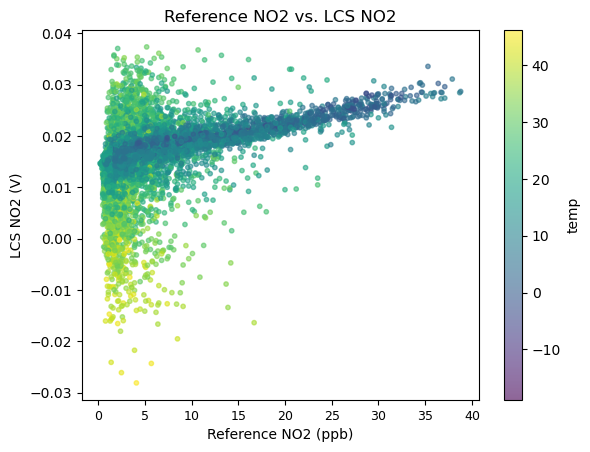

Figure 1: This is a scatter plot of the target variable (true NO2 value) against the voltage measured by the low-cost electrochemical NO2 sensor. This plot demonstrates that at low NO2 values, there is a large range of voltages, but that at higher NO2 values, the relationship turns linear.
 


In [13]:
# EDA

import matplotlib
from matplotlib import pylab as plt
import numpy as np

# Figure 1: Reference NO2 vs. low-cost NO2 voltage measurement
merge_df.plot.scatter('no2_ref','no2_wrk_aux',alpha=0.6,s=10, c="temp") # alpha=0.1,s=10
plt.xlabel('Reference NO2 (ppb)')
plt.xticks(fontsize=9)
plt.ylabel('LCS NO2 (V)')
plt.title('Reference NO2 vs. LCS NO2')
plt.savefig('EDA_figures/ref_v_lcs.png') 
plt.show() 

print("Figure 1: This is a scatter plot of the target variable (true NO2 value) against the voltage measured by the low-cost electrochemical NO2 sensor. This plot demonstrates that at low NO2 values, there is a large range of voltages, but that at higher NO2 values, the relationship turns linear.")
print(" ") 




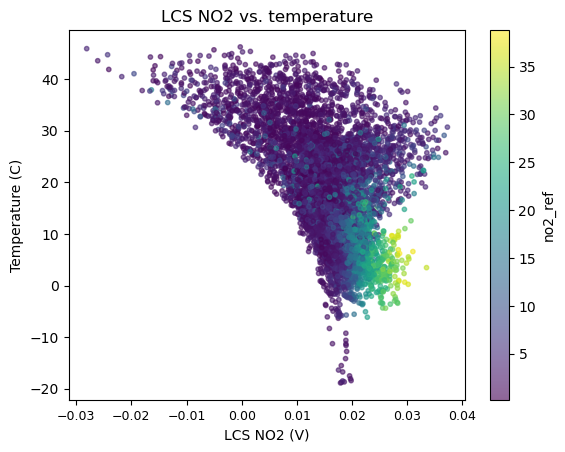

Figure 2: This is a scatter plot of the low-cost NO2 voltage compared to temperature (the sensor manual tells us that temperature affects sensor performance) We can see that there appears to be trend where at high temperatures, voltage measurements are more likely to be low or negative.
 


In [34]:
# Figure 2: Low-cost NO2 voltage measurement vs temperature
merge_df.plot.scatter('no2_wrk_aux','temp', alpha=0.6,s=10,c="no2_ref") # alpha=0.1,s=10
plt.xlabel('LCS NO2 (V)')
plt.xticks(fontsize=9)
plt.ylabel('Temperature (C)')
plt.title('LCS NO2 vs. temperature')
plt.savefig('EDA_figures/lcs_v_temp.png') 
plt.show() 
print("Figure 2: This is a scatter plot of the low-cost NO2 voltage compared to temperature (the sensor manual tells us that temperature affects sensor performance) We can see that there appears to be trend where at high temperatures, voltage measurements are more likely to be low or negative.")
print(" ")

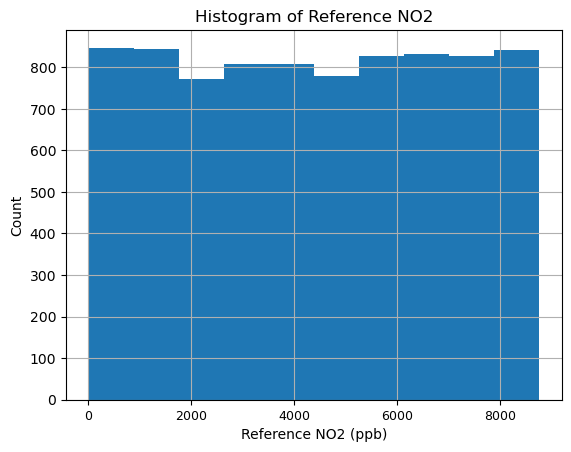

Figure 3: This is a simple histogram of the target variable. We can see that it is closer to a log-normal distribution, with most measurements at low NO2 concentrations and few at high concentrations. There is a potential need to stratify based on this.
 
 try taking the natural log of this!


In [84]:
# Figure 3: NO2_ref histogram
merge_df.hist('no2_ref')
plt.xlabel('Reference NO2 (ppb)')
plt.xticks(fontsize=9)
plt.ylabel('Count')
plt.title('Histogram of Reference NO2')
plt.savefig('EDA_figures/ref_hist.png') 

plt.show() 

print("Figure 3: This is a simple histogram of the target variable. We can see that it is closer to a log-normal distribution, with most measurements at low NO2 concentrations and few at high concentrations. There is a potential need to stratify based on this.")
print(" ")

print(" try taking the natural log of this!")


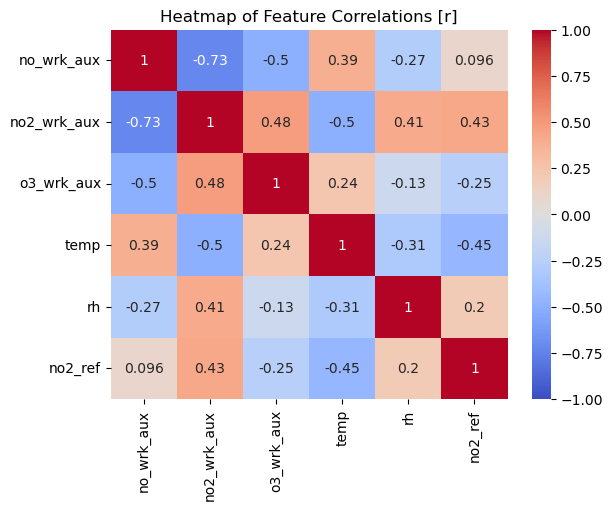

In [68]:
# Figure 4: Correlation matrix for features visualized as heatmap
import seaborn as sb
feats = merge_df[['no_wrk_aux','no2_wrk_aux','o3_wrk_aux','temp','rh','no2_ref']]
feat_corr = feats.corr(method='pearson')
sb.heatmap(feat_corr, cmap="coolwarm", annot=True, vmin=-1, vmax=1)
plt.title('Heatmap of Feature Correlations [r]')
plt.savefig('EDA_figures/corr_matrix.png') 



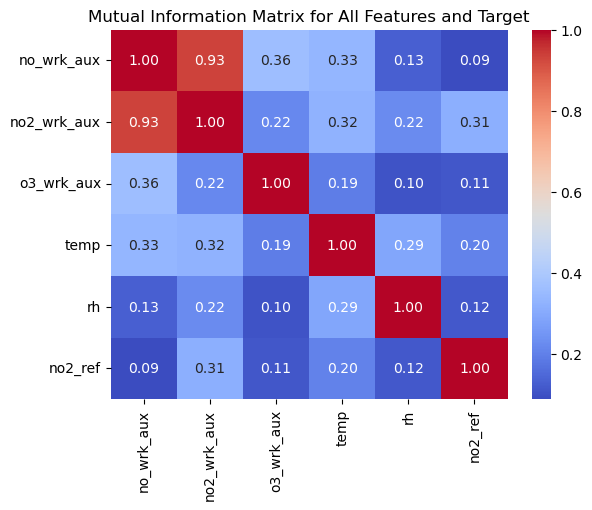

In [89]:
# Figure 5: Mutual information matrix visualized as a heatmap
## NON LINEAR CORRELATIONS

from sklearn.feature_selection import mutual_info_regression
merge_df_drop = merge_df.dropna()

df = merge_df_drop[['no_wrk_aux', 'no2_wrk_aux', 'o3_wrk_aux', 'temp', 'rh', 'no2_ref']]

# Initialize MI matrix
columns = df.columns
mi_matrix = pd.DataFrame(index=columns, columns=columns)

# Fill MI matrix for all pairs of columns
for i in range(len(columns)):
    for j in range(i, len(columns)):
        if i == j:
            mi_value = 1.0  # MI of a feature with itself is maximum (1)
        else:
            mi_value = mutual_info_regression(df[[columns[i]]], df[columns[j]])[0]
        mi_matrix.iloc[i, j] = mi_value
        mi_matrix.iloc[j, i] = mi_value  # Symmetric matrix

# Convert to numeric to avoid issues in heatmap
mi_matrix = mi_matrix.astype(float)

# Plot the MI matrix as a heatmap
sb.heatmap(mi_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mutual Information Matrix for All Features and Target')
plt.savefig('EDA_figures/MI_matrix.png') 
plt.show()

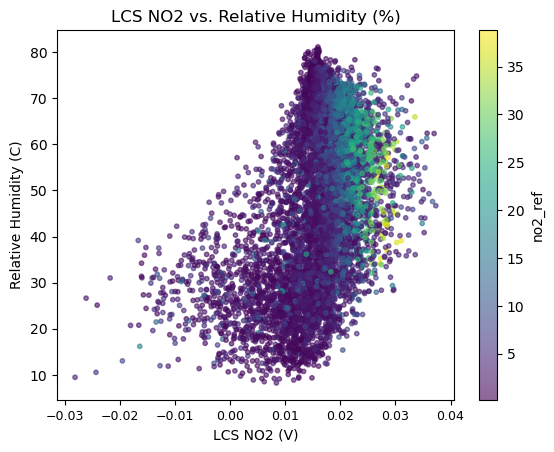

In [35]:
# Figure 6: Humidity vs LCS

merge_df.plot.scatter('no2_wrk_aux','rh', alpha=0.6,s=10,c="no2_ref") # alpha=0.1,s=10
plt.xlabel('LCS NO2 (V)')
plt.xticks(fontsize=9)
plt.ylabel('Relative Humidity (C)')
plt.title('LCS NO2 vs. Relative Humidity (%)')
plt.savefig('EDA_figures/lcs_v_rh.png') 
plt.show() 
print(" ")

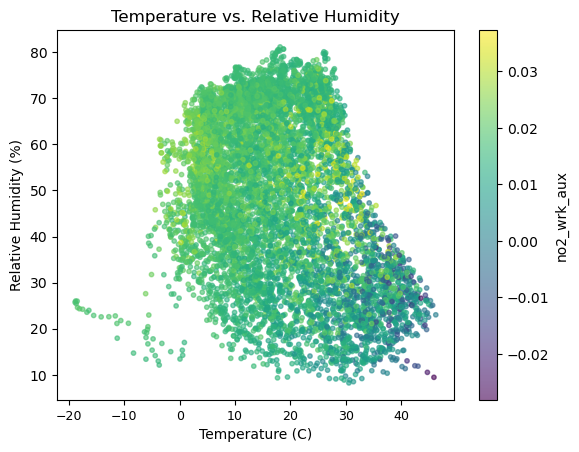

In [38]:
# Figure 7: temp vs RH

merge_df.plot.scatter('temp','rh', alpha=0.6,s=10,c="no2_wrk_aux") # alpha=0.1,s=10
plt.xlabel('Temperature (C)')
plt.xticks(fontsize=9)
plt.ylabel('Relative Humidity (%)')
plt.title('Temperature vs. Relative Humidity')
plt.savefig('EDA_figures/temp_v_rh.png') 
plt.show() 
print(" ")

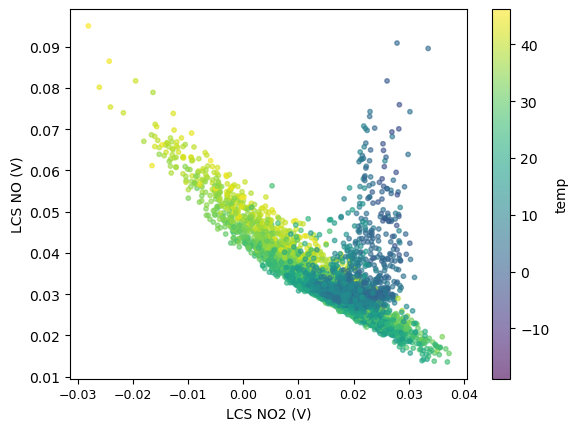

In [77]:
# Figure 8: LCS no2 vs no

merge_df.plot.scatter('no2_wrk_aux','no_wrk_aux', alpha=0.6,s=10,c="temp") # alpha=0.1,s=10
plt.xlabel('LCS NO2 (V)')
plt.xticks(fontsize=9)
plt.ylabel('LCS NO (V)')
plt.title('')
plt.savefig('EDA_figures/LCS_no2_no_coloredby_temp.png') 
plt.show() 
print(" ")

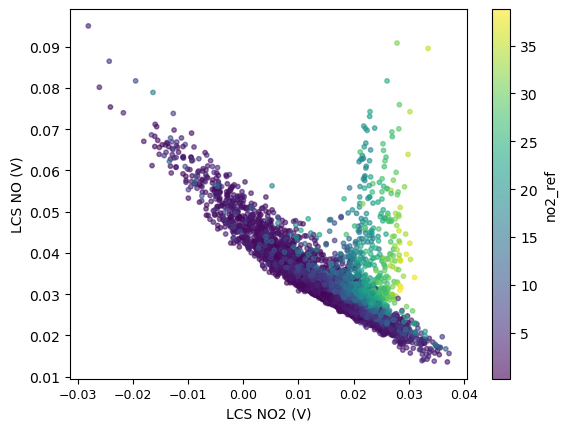

In [76]:
# Figure 8: LCS no2 vs no

merge_df.plot.scatter('no2_wrk_aux','no_wrk_aux', alpha=0.6,s=10,c="no2_ref") # alpha=0.1,s=10
plt.xlabel('LCS NO2 (V)')
plt.xticks(fontsize=9)
plt.ylabel('LCS NO (V)')
plt.title('')
plt.savefig('EDA_figures/LCS_no2_no_coloredby_ref.png') 
plt.show() 
print(" ")

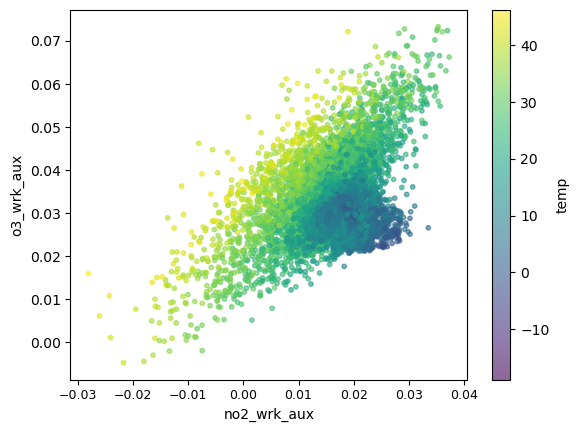

In [44]:
# Figure 9: LCS no2 vs o3

merge_df.plot.scatter('no2_wrk_aux','o3_wrk_aux', alpha=0.6,s=10,c="temp") # alpha=0.1,s=10
plt.xlabel('no2_wrk_aux')
plt.xticks(fontsize=9)
plt.ylabel('o3_wrk_aux')
plt.title('')
plt.savefig('EDA_figures/temp_v_rh.png') 
plt.show() 
print(" ")

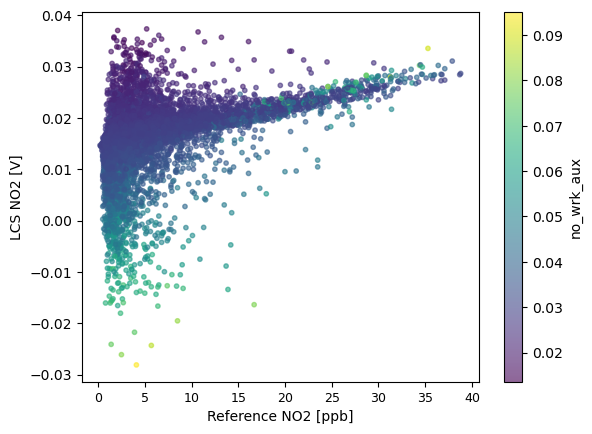

In [79]:
# Figure 9: LCS no2 vs ref NO2 colored by LCS NO

merge_df.plot.scatter('no2_ref','no2_wrk_aux', alpha=0.6,s=10,c="no_wrk_aux") # alpha=0.1,s=10
plt.xlabel('Reference NO2 [ppb]')
plt.xticks(fontsize=9)
plt.ylabel('LCS NO2 [V]')
plt.title('')
#plt.savefig('EDA_figures/temp_v_rh.png') 
plt.show() 
print(" ")

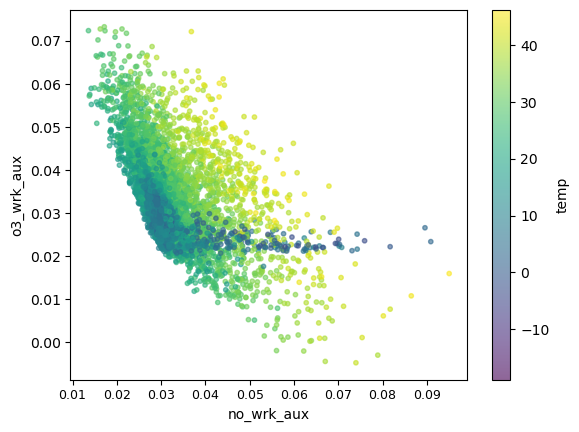

In [46]:
# Figure 10: LCS noo vs o3

merge_df.plot.scatter('no_wrk_aux','o3_wrk_aux', alpha=0.6,s=10,c="temp") # alpha=0.1,s=10
plt.xlabel('no_wrk_aux')
plt.xticks(fontsize=9)
plt.ylabel('o3_wrk_aux')
plt.title('')
#plt.savefig('EDA_figures/temp_v_rh.png') 
plt.show() 
print(" ")

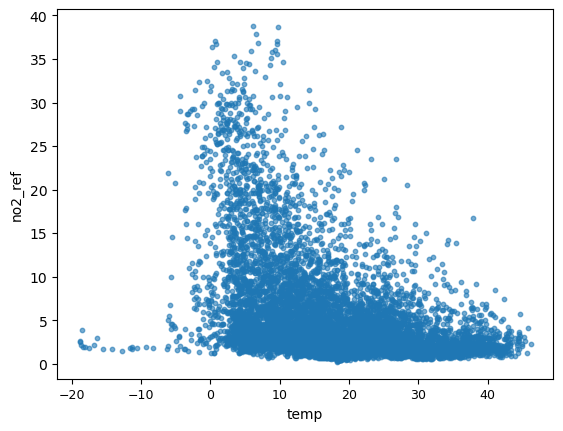

In [72]:
# Figure 11: Ref NO2 vs temperature

merge_df.plot.scatter('temp','no2_ref', alpha=0.6,s=10) # alpha=0.1,s=10
plt.xlabel('temp')
plt.xticks(fontsize=9)
plt.ylabel('no2_ref')
plt.title('')
plt.savefig('EDA_figures/temp_v_ref.png') 
plt.show() 
print(" ")


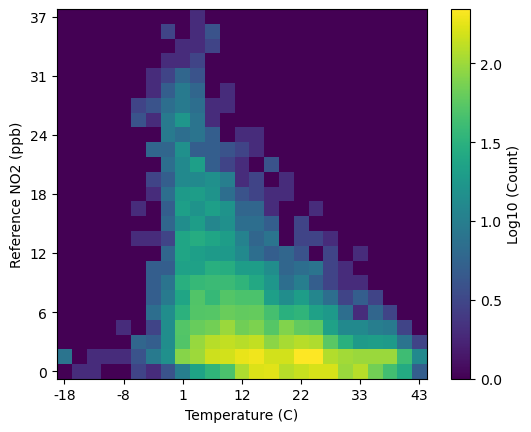

In [73]:
# Figure 12: Ref NO2 vs temperature heatmap

nbins = 25 # changing the bin number changes the size of the heat map pixel
cleaned_df = merge_df.dropna(subset=['temp', 'no2_ref'])
heatmap, xedges, yedges = np.histogram2d(cleaned_df['temp'], cleaned_df['no2_ref'], bins=nbins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

heatmap[heatmap == 0] = 0.1 # we will use log and log(0) is undefined, plenty of bins where 0 people fall into it, replace with small but non-zero number
plt.figure()

plt.imshow(np.log10(heatmap).T, origin='lower',vmin=0) # using log count
#plt.imshow(heatmap.T, origin='lower',vmin=0) # not using log count
# using log count can give you more relative detail 
plt.xlabel('Temperature (C)')
plt.ylabel('Reference NO2 (ppb)')
plt.xticks(np.arange(nbins+1)[::4],xedges[::4].astype(int)) # don't totally understand this
plt.yticks(np.arange(nbins+1)[::4],yedges[::4].astype(int))
plt.colorbar(label='Log10 (Count)')
plt.savefig('EDA_figures/temp_v_ref_heatmap.png') 
plt.show()

0.13391984359726294


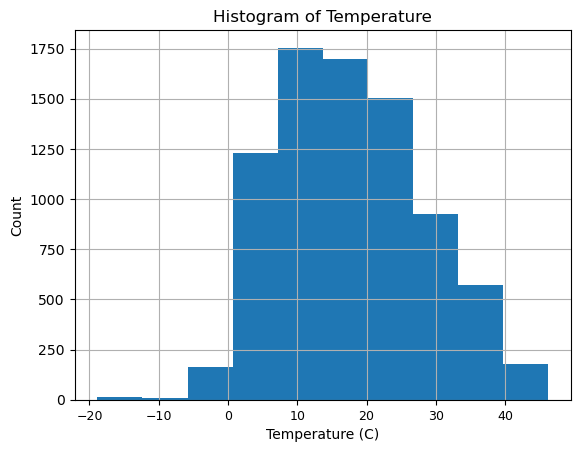

In [15]:
# Calculate percentage of measurements at > 30C

merge_df.shape[0]
perc_high_t = (merge_df['temp'] >= 30).sum() / merge_df.shape[0]
print(perc_high_t)

# Figure 3: temp histogram
merge_df.hist('temp')
plt.xlabel('Temperature (C)')
plt.xticks(fontsize=9)
plt.ylabel('Count')
plt.title('Histogram of Temperature')
plt.savefig('EDA_figures/temp_hist.png') 

plt.show() 


In [5]:
# Calculate proportion of missing data for each parameter

# calculate what fraction of each feature is missing data
perc_missing_per_ftr = merge_df.isnull().sum(axis=0)/merge_df.shape[0]
print('Fraction of missing values in each feature:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

#print(merge_df.head())


Fraction of missing values in each feature:
node_id        0.01674
sensor_name    0.01674
no_wrk_aux     0.01674
no2_wrk_aux    0.01674
o3_wrk_aux     0.01674
temp           0.01674
rh             0.01674
dtype: float64


In [6]:
# NOTE! I SHOULD THINK ABOUT THAT FUNCTION THAT MULTIPLIES FEATURES AND SQUARES THEM ETC

# STRATIFY BASED ON REGRESSION VARIABLE QUINTILES!

# I CAN SAY THAT THIS IS IID


# Show rows with missing values
missing_rows = merge_df[merge_df.isnull().any(axis=1)]
print(missing_rows)


      Unnamed: 0                       date  node_id sensor_name  no_wrk_aux  \
4514        4840  2023-07-21 16:00:00-04:00      NaN         NaN         NaN   
7421        7965  2023-11-28 20:00:00-05:00      NaN         NaN         NaN   
7422        7966  2023-11-28 21:00:00-05:00      NaN         NaN         NaN   
7423        7967  2023-11-28 22:00:00-05:00      NaN         NaN         NaN   
7424        7968  2023-11-28 23:00:00-05:00      NaN         NaN         NaN   
...          ...                        ...      ...         ...         ...   
7655        8207  2023-12-08 22:00:00-05:00      NaN         NaN         NaN   
7656        8208  2023-12-08 23:00:00-05:00      NaN         NaN         NaN   
7657        8209  2023-12-09 00:00:00-05:00      NaN         NaN         NaN   
7666        8218  2023-12-09 09:00:00-05:00      NaN         NaN         NaN   
7671        8223  2023-12-09 14:00:00-05:00      NaN         NaN         NaN   

      no2_wrk_aux  o3_wrk_aux  temp  rh